In [8]:
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from visualization.modules import Normalization
from visualization.style_transfer import *

In [9]:
from pathlib import Path
from fastai.basic_train import load_learner

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


In [12]:
content_img = image_loader("/home/jupyter/data/" + "markus_pp.jpg")
style_img = image_loader("/home/jupyter/data/" + "hendrix.jpg")

style_img = style_img[:, :3, :, :512]
content_img.shape
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [13]:
unloader = transforms.ToPILImage()  # reconvert into PIL image
plt.ion()
def imshow(tensor, ax=None, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    if ax is None:
        ax = plt
        title_setter = plt.title
    else:
        title_setter = ax.set_title
    ax.imshow(image)
    ax.axis('off')
    if title is not None:
        title_setter(title)
    #plt.pause(0.001) # pause a bit so that plots are updated


In [15]:
#encode in strings
#import trained model
#run style transfer with config
#save input, output
#save config as JSON
#callback for 'run style transfer'

#serialize JSON
#product 

#vgg19_age_2.pkl
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
style_img = style_img[:, :3, :, :512]
#product(styles, content)
batch_config = {
    #all relations and tweaking is assumed a cartesian product of params
    "model_path": "/home/jupyter/models/",
    "model": "vgg19_age_2.pkl", #TODO: model_meta: information about models trained...
    "loss_func": "",
    "style_content_pairs": [ #can run multiple pair, inputs
        ("/home/jupyter/data/" + "hendrix.jpg", 
         "/home/jupyter/data/" + "markus_pp.jpg"
         )
    ],
    #"optimizer": "LGTB",
    #"callback": "...",
    "style_transfer_optim_v": 0.1,
    "style_injects": [['conv-4','conv-5', 'conv-8']],
    #['conv-5'], ['conv-4', 'conv-7'] -- was good 
    "content_injects": [['conv-5']],
    "epochs": 600,
    "save_every_x_epoch": 50, #non-linear might be better
    "tv_weight": 0.05,
    "output_path":"/home/jupyter/data/style_transfers_3/",
    "outputs": "..."
    #just sketching the output file here - not config
    #"outputs": [{"epoch": 100, img_path:"..." }]
}


In [16]:
from datetime import datetime
from pathlib import Path
import json
from PIL import Image

In [17]:
#add %timer to params -- know how long the training took
from numpy import random
def hyperparam_traverse(config, use_noise=False, verbose=True):
    #const {id, name, x} = obj
    outpath = config["output_path"]
    #SETUP ARCH
    learner = load_learner(path = config["model_path"], file = "vgg19_age_2.pkl")
    cnn = learner.model[0][0]
    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    
    arch = LayeredModule.from_cnn(cnn, Normalization(cnn_normalization_mean, cnn_normalization_std).to(device))
    #iteration logic later
    style_p, content_p = config["style_content_pairs"][0]
    style_img = image_loader(style_p)
    style_img = style_img[:, :3, :, :512]

    content_img = image_loader(content_p)    

    assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"
    
    #luckily content doesn't vary...
    content_injects = config["content_injects"]
 

    #for loop here over permutations
    for content_inject in config['content_injects']:
        for style_inject in config["style_injects"]:
        
            style_module = StyleTransferModule(
            arch, 
            content_target=content_img, 
            content_layer_keys=content_inject, #TRY AGAIN WITH CONTENT 
            style_target=style_img, 
            style_layer_keys=style_inject)

                #TODO try noise instead
             #TODO try noise instead
            if use_noise: 
                input_img = torch.rand(content_img.size()).to(device)
            else:
                input_img = content_img.clone()
            # style_injects = config["style_injects"]
            folder_name = "style"
            for s in style_inject:
                folder_name += "-" + s.split("-")[1]
            folder_name += "_content"
            for c in content_inject:
                folder_name += "-" + c.split("-")[1]
            folder_name += "/"
            
            filepath = outpath + folder_name
            
            p = Path(filepath)
            print(p)
            p.mkdir(parents=True, exist_ok=True)
            conf = config.copy()
            conf['date'] = datetime.now().strftime("%m_%d_%Y, %H:%M:%S")
            conf["outputs"] = []

            conf["style_injects"] = style_inject
            conf["content_injects"] = content_inject

            def tap_closure(epoch, img, style_loss, content_loss, ):                
                if epoch % config["save_every_x_epoch"] != 0: 
                    return
                image = img.cpu().clone()  # we clone the tensor to not do changes on it
                image = image.squeeze(0)      # remove the fake batch dimension
                image = unloader(image)
                SL = str(round(style_loss))
                CL = str(round(content_loss))
                print("SL:  ", SL, "CL:  ", CL)
                fname = str(epoch) + "_SL_" + SL + "_CL_" + CL
                conf["outputs"].append({"epoch": epoch, "image": fname, "style_loss": SL, "content_loss": CL})
                image.save(p / (fname + ".jpg"), 'JPEG')

            #print(str(style_inject))
            output = style_module.run_style_transfer(input_img, num_steps=config["epochs"], tv_weight=config["tv_weight"], callback=tap_closure, verbose=verbose)


            #SAVE CONFIG
            confpath = filepath + "config.json"
            
            #json.dump(conf, default=lambda o: o.__dict__, indent=4)
            with open(confpath, 'w') as outfile:
                print(confpath)
                json.dump(conf, outfile)

            plt.figure()
            imshow(output, title='Output Image')
            plt.show()

    return output 

/home/jupyter/vision-playground/nbs/playground/visualization/modules.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/home/jupyter/vision-playground/nbs/playground/visualization/modules.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


/home/jupyter/data/style_transfers_3/style-4-5-8_content-5
Optimizing...
SL:   679394 CL:   0
run [50]:
Style Loss : 2551.926025 Content Loss: 237.099091

SL:   2453 CL:   237
run [100]:
Style Loss : 758.778687 Content Loss: 240.429214

SL:   739 CL:   241
run [150]:
Style Loss : 493.437408 Content Loss: 240.716492

SL:   509 CL:   240
run [200]:
Style Loss : 457.348236 Content Loss: 239.726334

SL:   411 CL:   241
run [250]:
Style Loss : 345.950165 Content Loss: 241.726440

SL:   327 CL:   243
run [300]:
Style Loss : 1087.697632 Content Loss: 244.624573

SL:   1189 CL:   246
run [350]:
Style Loss : 293.455780 Content Loss: 245.413162

SL:   290 CL:   245
run [400]:
Style Loss : 273.607330 Content Loss: 244.054031

SL:   268 CL:   245
run [450]:
Style Loss : 23284.265625 Content Loss: 247.881638

SL:   15314 CL:   249
run [500]:
Style Loss : 398.113312 Content Loss: 248.766647

SL:   398 CL:   249
run [550]:
Style Loss : 270.732513 Content Loss: 247.353607

SL:   271 CL:   247
run [600

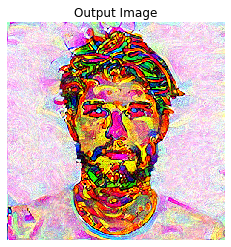

tensor([[[[0.5790, 0.6044, 0.6049,  ..., 0.7716, 0.7648, 0.7452],
          [0.6565, 0.6350, 0.5555,  ..., 0.7912, 0.7407, 0.7814],
          [0.6115, 0.6597, 0.5675,  ..., 0.8468, 0.8602, 0.8847],
          ...,
          [0.0632, 0.1880, 0.8437,  ..., 0.7547, 0.6928, 0.6430],
          [0.0212, 0.0885, 0.7798,  ..., 0.6518, 0.6849, 0.6282],
          [0.1499, 0.0650, 0.8642,  ..., 0.6550, 0.6714, 0.6291]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.8601, 0.8496, 0.9154],
          [1.0000, 1.0000, 1.0000,  ..., 0.9172, 0.9752, 0.8642],
          [1.0000, 1.0000, 1.0000,  ..., 0.7401, 0.7975, 0.8342],
          ...,
          [0.2195, 0.2869, 0.5076,  ..., 0.9714, 0.9619, 0.9401],
          [0.5158, 0.5372, 1.0000,  ..., 0.9617, 0.9269, 0.8807],
          [0.3761, 0.4767, 1.0000,  ..., 0.9120, 0.8353, 0.8848]],

         [[0.7093, 0.7879, 0.7416,  ..., 0.9794, 1.0000, 0.9851],
          [0.7446, 0.7155, 0.7004,  ..., 0.9106, 0.9940, 1.0000],
          [0.8673, 0.8356, 0.7981,  ..., 1

In [18]:
hyperparam_traverse(batch_config)

/home/jupyter/data/style_transfers_3/style-4-5-8_content-5
Optimizing...
SL:   679394 CL:   0
run [50]:
Style Loss : 2551.926025 Content Loss: 237.099091

SL:   2453 CL:   237
run [100]:
Style Loss : 758.778687 Content Loss: 240.429214

SL:   739 CL:   241
run [150]:
Style Loss : 493.437408 Content Loss: 240.716492

SL:   509 CL:   240
run [200]:
Style Loss : 457.348236 Content Loss: 239.726334

SL:   411 CL:   241
run [250]:
Style Loss : 345.950165 Content Loss: 241.726440

SL:   327 CL:   243
run [300]:
Style Loss : 1087.697632 Content Loss: 244.624573

SL:   1189 CL:   246
run [350]:
Style Loss : 293.455780 Content Loss: 245.413162

SL:   290 CL:   245
run [400]:
Style Loss : 273.607330 Content Loss: 244.054031

SL:   268 CL:   245
run [450]:
Style Loss : 23284.265625 Content Loss: 247.881638

SL:   15314 CL:   249
run [500]:
Style Loss : 398.113312 Content Loss: 248.766647

SL:   398 CL:   249
run [550]:
Style Loss : 270.732513 Content Loss: 247.353607

SL:   271 CL:   247
run [600

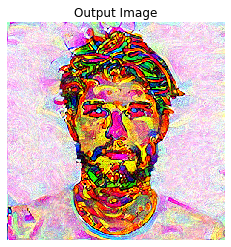

tensor([[[[0.5790, 0.6044, 0.6049,  ..., 0.7716, 0.7648, 0.7452],
          [0.6565, 0.6350, 0.5555,  ..., 0.7912, 0.7407, 0.7814],
          [0.6115, 0.6597, 0.5675,  ..., 0.8468, 0.8602, 0.8847],
          ...,
          [0.0632, 0.1880, 0.8437,  ..., 0.7547, 0.6928, 0.6430],
          [0.0212, 0.0885, 0.7798,  ..., 0.6518, 0.6849, 0.6282],
          [0.1499, 0.0650, 0.8642,  ..., 0.6550, 0.6714, 0.6291]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.8601, 0.8496, 0.9154],
          [1.0000, 1.0000, 1.0000,  ..., 0.9172, 0.9752, 0.8642],
          [1.0000, 1.0000, 1.0000,  ..., 0.7401, 0.7975, 0.8342],
          ...,
          [0.2195, 0.2869, 0.5076,  ..., 0.9714, 0.9619, 0.9401],
          [0.5158, 0.5372, 1.0000,  ..., 0.9617, 0.9269, 0.8807],
          [0.3761, 0.4767, 1.0000,  ..., 0.9120, 0.8353, 0.8848]],

         [[0.7093, 0.7879, 0.7416,  ..., 0.9794, 1.0000, 0.9851],
          [0.7446, 0.7155, 0.7004,  ..., 0.9106, 0.9940, 1.0000],
          [0.8673, 0.8356, 0.7981,  ..., 1

In [19]:
hyperparam_traverse(batch_config)

In [20]:
from itertools import product, chain, combinations, permutations
from random import sample 
conv_layer_indices = list(range(0, 16))

In [21]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

layer_combos =  [list(subs) for subs in powerset(list(range(0, 16))) if subs != () ]

In [22]:

samp = sample(layer_combos,k=1000)
samp_layers = [
    [f'conv-{i}' for i in subsamp]
    for subsamp in samp]
samp_layers[:3]

[['conv-0',
  'conv-1',
  'conv-5',
  'conv-7',
  'conv-8',
  'conv-9',
  'conv-11',
  'conv-13'],
 ['conv-1', 'conv-2', 'conv-5', 'conv-7', 'conv-9', 'conv-13'],
 ['conv-0', 'conv-4', 'conv-6', 'conv-7', 'conv-8', 'conv-14', 'conv-15']]

/home/jupyter/data/style_transfers_3/style-0-1-5-7-8-9-11-13_content-5
Optimizing...
SL:   2264040 CL:   0
SL:   16114 CL:   234
SL:   4730 CL:   242
SL:   2359 CL:   245
SL:   1589 CL:   246
SL:   1351 CL:   246
SL:   1204 CL:   246
SL:   40571 CL:   272
SL:   5618 CL:   280
SL:   2300 CL:   281
SL:   1470 CL:   280
SL:   1032 CL:   279
SL:   913 CL:   279
/home/jupyter/data/style_transfers_3/style-0-1-5-7-8-9-11-13_content-5/config.json


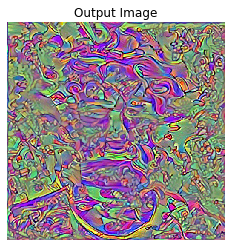

/home/jupyter/data/style_transfers_3/style-1-2-5-7-9-13_content-5
Optimizing...
SL:   1912131 CL:   0
SL:   20034 CL:   232
SL:   7622 CL:   244
SL:   2520 CL:   247
SL:   1465 CL:   247
SL:   1170 CL:   247
SL:   1014 CL:   246
SL:   894 CL:   247
SL:   181806 CL:   249
SL:   6595 CL:   256
SL:   1442 CL:   259
SL:   837 CL:   258
SL:   632 CL:   258
/home/jupyter/data/style_transfers_3/style-1-2-5-7-9-13_content-5/config.json


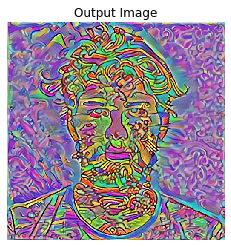

/home/jupyter/data/style_transfers_3/style-0-4-6-7-8-14-15_content-5
Optimizing...
SL:   2125602 CL:   0
SL:   14350 CL:   226
SL:   2735 CL:   231
SL:   1271 CL:   234
SL:   904 CL:   235
SL:   802 CL:   235
SL:   779 CL:   235
SL:   643 CL:   235
SL:   49662 CL:   254
SL:   2640 CL:   242
SL:   1185 CL:   243
SL:   733 CL:   243
SL:   593 CL:   242
/home/jupyter/data/style_transfers_3/style-0-4-6-7-8-14-15_content-5/config.json


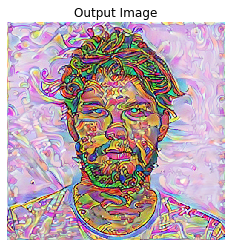

/home/jupyter/data/style_transfers_3/style-5-6-7-12-15_content-5
Optimizing...
SL:   1909696 CL:   0
SL:   12660 CL:   240


In [ ]:
bc = batch_config.copy()
samp
bc["style_injects"] = samp_layers
hyperparam_traverse(bc, verbose=False)